# Segmentation of PanNuke Dataset

# 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm
import os
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
import cv2
import pickle

/home/andrea/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Configuration
Define model and training configurations for PanNuke dataset.

In [2]:
config = {
    # Model parameters
    "image_size": 256,
    "patch_size": 16,
    "num_channels": 3,
    "hidden_size": 512,
    "num_attention_heads": 4,
    "num_hidden_layers": 7,
    "intermediate_size": 1024,
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "embedding_channels": [64, 128, 256],
    
    # Segmentation parameters
    "num_classes": 6,  # 5 nuclei types + Background
    "decoder_channels": [256, 128, 64, 16],
    "conv_channels": [64, 128, 256, 512],
    
    # Dataset paths
    "root_dir": "pannuke-segmentation/data",
    "train_fold": 1,
    "val_fold": 2,
    "test_fold": 3,
    
    # Training parameters
    "batch_size": 16,
    "num_epochs": 50,
    "learning_rate": 0.01,
    "patient": 15,
    "seed": 1234
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(config["seed"])

Using device: cuda


### Dataset and DataLoader
PanNuke dataset integration with albumentations transforms.

In [3]:
class PanNukeDataset(Dataset):
    def __init__(self, root_dir, fold, transform):
        """
            root_dir (str): Path to dataset directory
            fold (int): Fold number (1, 2, or 3)
            transform (callable): Optional transform to apply
        """
        # Paths to .npy files
        self.images_path = os.path.join(root_dir, f"Fold {fold}", "images", f"fold{fold}", "images.npy")
        self.masks_path = os.path.join(root_dir, f"Fold {fold}", "masks", f"fold{fold}", "masks.npy")
        self.types_path = os.path.join(root_dir, f"Fold {fold}", "images", f"fold{fold}", "types.npy")

        # use memory-mapped loading (keep the array on disk) to avoid loading entire arrays into RAM at once when accessing [r = reading only] 
        self.images = np.load(self.images_path, mmap_mode='r')  # N x W x H x 3
        self.masks = np.load(self.masks_path, mmap_mode='r')    # N x W x H x 6 (one-hot)

        self.transform = transform

    def __len__(self):
        return len(self.images)  # length determined by images array

    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()   # H x W x 6 (one-hot channels)

        # Convert one-hot mask to single-channel class map
        # PanNuke ordering: channels 0..4 = nuclei classes, 5 = background
        mask = np.argmax(mask, axis=2)  # H x W with values in [0..5]

        # Remap labels so background becomes 0 (important when rotating in data augmentations)
        # 0->1, 1->2, 2->3, 3->4, 4->5, 5->0
        remap = np.array([1, 2, 3, 4, 5, 0])
        mask = remap[mask]

        image = (image / 255).astype(np.float32)  # Normalize image pixels to [0, 1], from FP64 to FP32

        transformed = self.transform(image=image, mask=mask)  # from HWC numpy to CHW tensor
        image = transformed["image"]
        mask = transformed["mask"]  # int32

        return {'image': image, 'label': mask}


# Define transforms
train_transform = A.Compose([
    A.Rotate(
        limit=360, p=0.8,
        border_mode=cv2.BORDER_CONSTANT,        # fill outside pixels with constant 0 value
        interpolation=cv2.INTER_LINEAR,         # weighted average of its nearest 4 pixels
        mask_interpolation=cv2.INTER_NEAREST    # nearest for masks to keep integer labels
    ),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(
        config["image_size"], config["image_size"],
        interpolation=cv2.INTER_LINEAR,
        mask_interpolation=cv2.INTER_NEAREST
    ),
    ToTensorV2()  # converts image/mask to torch tensors
])

val_transform = A.Compose([
    A.Resize(
        config["image_size"], config["image_size"],
        interpolation=cv2.INTER_LINEAR,
        mask_interpolation=cv2.INTER_NEAREST
    ),
    ToTensorV2()
])

# Create datasets for chosen folds
train_dataset = PanNukeDataset(
    root_dir=config["root_dir"],
    fold=config["train_fold"],
    transform=train_transform
)

val_dataset = PanNukeDataset(
    root_dir=config["root_dir"],
    fold=config["val_fold"],
    transform=val_transform
)

test_dataset = PanNukeDataset(
    root_dir=config["root_dir"],
    fold=config["test_fold"],
    transform=val_transform
)

def worker_init_fn(worker_id):     
    random.seed(config["seed"] + worker_id)  # seed Python's random for the worker_id

train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=4,    # make it quicker allowing data loading during other blocking activities
    worker_init_fn=worker_init_fn  # setup the seed for each worker
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=2,
    worker_init_fn=worker_init_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=2,
    worker_init_fn=worker_init_fn
)

print(f"Training samples: {len(train_dataset)}, training batches: {len(train_loader)}")
print(f"Validation samples: {len(val_dataset)}, validation batches: {len(val_loader)}")
print(f"Test samples: {len(test_dataset)}, test batches: {len(test_loader)}")

sample = train_dataset[0]
print(f"\nTraining sample shape: {sample['image'].shape}, {sample['label'].shape}")

Training samples: 2656, training batches: 166
Validation samples: 2523, validation batches: 158
Test samples: 2722, test batches: 171

Training sample shape: torch.Size([3, 256, 256]), torch.Size([256, 256])


### Class Labels and Visualization Settings

Visualizing 4 random training samples


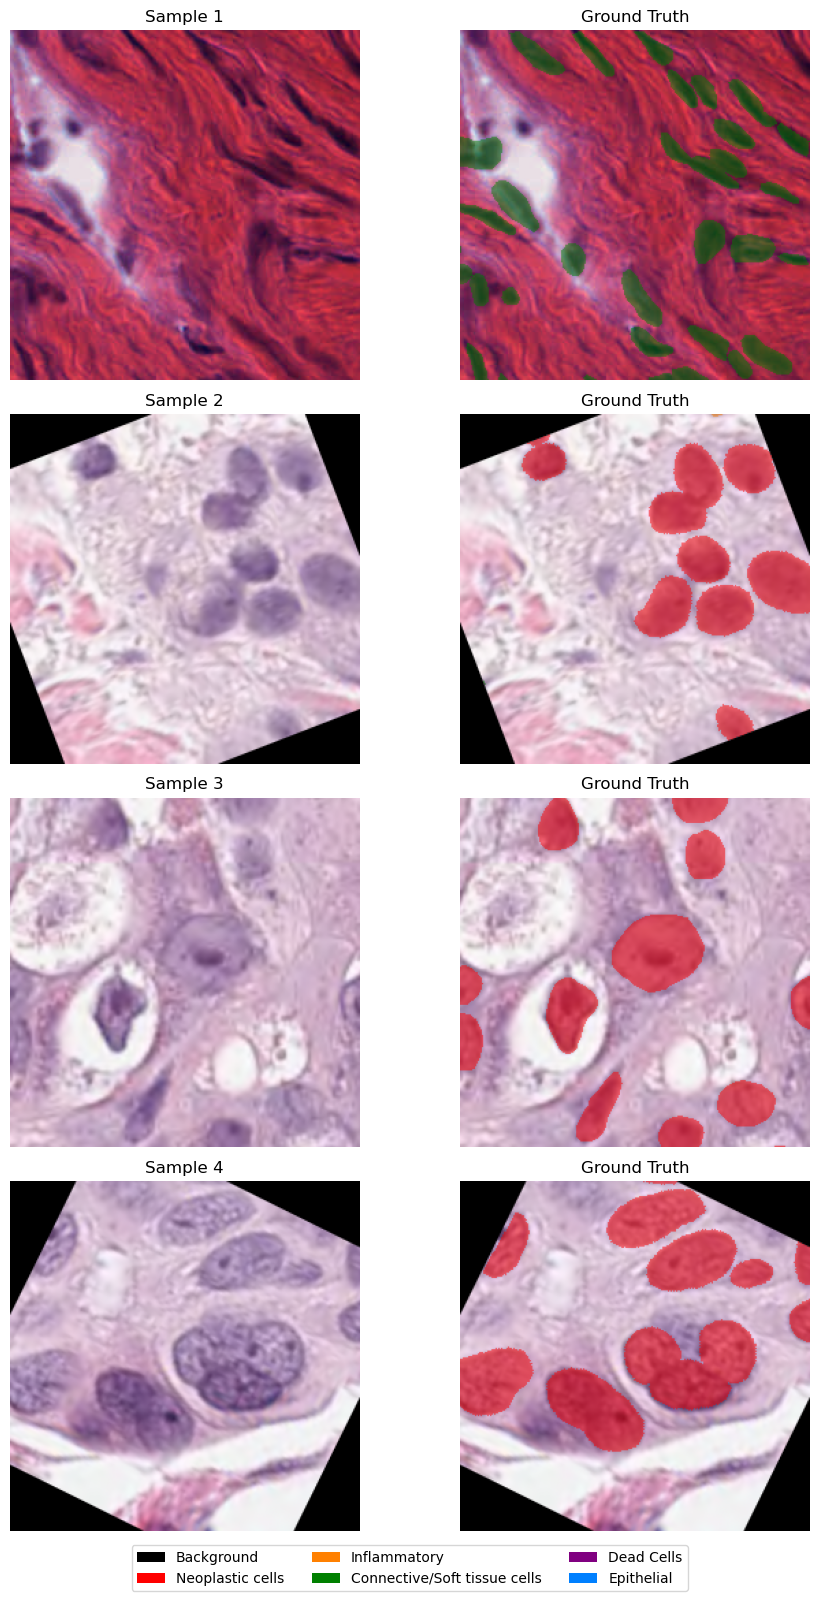

In [4]:
# PanNuke 6-class segmentation labels (Background is 0)
CLASS_NAMES = {
    0: 'Background',
    1: 'Neoplastic cells',
    2: 'Inflammatory',
    3: 'Connective/Soft tissue cells',
    4: 'Dead Cells',
    5: 'Epithelial'
}

# Colors per class (RGB in [0,1])
CLASS_COLORS = {
    0: [0.0, 0.0, 0.0],    # Background - Black
    1: [1.0, 0.0, 0.0],    # Neoplastic - Red
    2: [1.0, 0.5, 0.0],    # Inflammatory - Orange
    3: [0.0, 0.5, 0.0],    # Connective - Dark Green
    4: [0.5, 0.0, 0.5],    # Dead - Purple
    5: [0.0, 0.5, 1.0]     # Epithelial - Sky Blue
}


def mask_to_rgb(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.float32)
    for class_id, color in CLASS_COLORS.items():
        rgb[mask == class_id] = color
    return rgb


def overlay_mask_on_image(image, mask, alpha=0.5, background_class=0):
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    mask_rgb = mask_to_rgb(mask)
    overlay = image.copy()

    mask_binary = (mask != background_class)  # do not show background class in overlay
    overlay[mask_binary] = (1 - alpha) * image[mask_binary] + alpha * mask_rgb[mask_binary]
    return overlay


def create_legend():
    legend_elements = [
        Patch(facecolor=CLASS_COLORS[i], label=CLASS_NAMES[i]) # type: ignore
        for i in range(0, 6)
    ]
    return legend_elements


# Plotting utilities for PanNuke
def plot_samples(images, labels, predictions=None, num_samples=4, alpha=0.5):
    show_pred = predictions is not None   # used with predictions of a model
    ncols = 3 if show_pred else 2
    
    fig, axes = plt.subplots(num_samples, ncols, figsize=(5*ncols, 4*num_samples))
    
    for i in range(num_samples):
        img = images[i].cpu().numpy()
        gt = labels[i].cpu().numpy()
        axes[i, 0].imshow(img.transpose(1, 2, 0))
        axes[i, 0].set_title(f'Sample {i+1}')
        axes[i, 0].axis('off')
        
        gt_overlay = overlay_mask_on_image(img, gt, alpha=alpha, background_class=0)
        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        if show_pred:
            pred = predictions[i].cpu().numpy()
            pred_overlay = overlay_mask_on_image(img, pred, alpha=alpha, background_class=0)
            axes[i, 2].imshow(pred_overlay)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
    
    legend_elements = create_legend()
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.04)
    plt.show()

# Visualize random training samples
num_viz = 4
indices = random.sample(range(len(train_dataset)), num_viz)

images = []
labels = []

for idx in indices:
    sample = train_dataset[idx]
    images.append(sample['image'])
    labels.append(sample['label'])

images = torch.stack(images)
labels = torch.stack(labels)

print(f"Visualizing {num_viz} random training samples")
plot_samples(images, labels, num_samples=num_viz)

# 3. Models Definitions

## 3.1 ResNetUnet

In [5]:
# Define a Basic Convolution Block (Conv3x3 -> BN -> ReLU)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)   # Bias useless after BatchNormalization
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        # Downsample is a module that takes the input and downsample it to in_channels
        super(ResBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn(self.conv2(out))
        out += identity
        return self.relu(out)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(DownBlock, self).__init__()
        downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),   # Bias useless after BatchNormalization
            nn.BatchNorm2d(out_channels)
        )
        self.resblock = ResBlock(in_channels, out_channels, stride, downsample)

    def forward(self, x):
        return self.resblock(x)


# Define the Up-Block with skip_connection for UNet Decoder
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=True):
        super(UpBlock, self).__init__()
        if upsample:
            self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        else:
            self.upsample = None

        self.double_conv = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x, skip_connection):
        if self.upsample:
            x = self.upsample(x)
            
        x = torch.cat((x, skip_connection), dim=1)
        return self.double_conv(x)


# Define the UNet with ResNet Encoder
class ResNetUNet(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super(ResNetUNet, self).__init__()

        # Initial Convolution
        self.initial_conv = ConvBlock(in_channels, features[0])  # (from 3 channels to 64 channels)

        # Encoder
        self.encoders = nn.ModuleList()
        for idx, feature in enumerate(features):
            if idx == 0:
                self.encoders.append(ResBlock(features[idx], features[idx]))    # do not downsample the image for the fist Block
            else:
                self.encoders.append(DownBlock(features[idx - 1], features[idx]))

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvBlock(features[-1], features[-1] * 2),
            ConvBlock(features[-1] * 2, features[-1])
        )

        # Decoder
        self.decoders = nn.ModuleList()
        reversed_features = features[::-1]
        for idx, feature in enumerate(reversed_features):
            if idx == 0:
                self.decoders.append(UpBlock(features[-1]*2, feature, upsample=False))  # do not upsample for the first block 
            else:
                self.decoders.append(UpBlock(reversed_features[idx - 1], feature))

        # Final Convolution -> output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        skip_connections = []
        x = self.initial_conv(x)
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]
        for idx, decoder in enumerate(self.decoders):
            x = decoder(x, skip_connections[idx])

        return self.final_conv(x)
    

resNetUNet = ResNetUNet(in_channels=config["num_channels"], out_channels=config["num_classes"], features=config["conv_channels"])

summary(
    resNetUNet, 
    input_size=(1, config["num_channels"], config["image_size"], config["image_size"]),
    col_names=["input_size", "output_size", "num_params"],
    depth=4,
    verbose=1
)

print("")

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
ResNetUNet                                    [1, 3, 256, 256]          [1, 6, 256, 256]          --
├─ConvBlock: 1-1                              [1, 3, 256, 256]          [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                            [1, 3, 256, 256]          [1, 64, 256, 256]         1,728
│    └─BatchNorm2d: 2-2                       [1, 64, 256, 256]         [1, 64, 256, 256]         128
│    └─ReLU: 2-3                              [1, 64, 256, 256]         [1, 64, 256, 256]         --
├─ModuleList: 1-2                             --                        --                        --
│    └─ResBlock: 2-4                          [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    └─ConvBlock: 3-1                    [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    │    └─Conv2d: 4-1                  [1, 64, 256, 256]         [1, 64, 25

## 3.2 Vision Transformer Components

Embeddings and Positional Embeddings

In [6]:
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        embedding_channels = config["embedding_channels"]
        self.num_patches = (config["image_size"] // 16) ** 2

        # Bias is useless if used in a convolution, before BatchNormalization
        self.conv0 = nn.Conv2d(config["num_channels"], embedding_channels[0], kernel_size=3, padding=1, bias=False)   # upsample the channels (3 -> 64)
        self.bn0 = nn.BatchNorm2d(embedding_channels[0])
        self.act0 = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(embedding_channels[0], embedding_channels[0], kernel_size=3, padding=1, bias=False, stride=2)  # downsample the image
        self.bn1 = nn.BatchNorm2d(embedding_channels[0])
        self.act1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(embedding_channels[0], embedding_channels[1], kernel_size=3, padding=1, bias=False, stride=2)
        self.bn2 = nn.BatchNorm2d(embedding_channels[1])
        self.act2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(embedding_channels[1], embedding_channels[2], kernel_size=3, padding=1, bias=False, stride=2)  
        self.bn3 = nn.BatchNorm2d(embedding_channels[2])
        self.act3 = nn.ReLU(inplace=True)

        self.projection = nn.Conv2d(in_channels=embedding_channels[2], out_channels=config["hidden_size"], kernel_size=3, stride=2, padding=1 )  # final shape: (B, hidden_size, 16, 16)

    def forward(self, x):  # x: (B, C, 256, 256)
        y0 = self.act0(self.bn0(self.conv0(x)))
        y1 = self.act1(self.bn1(self.conv1(y0)))      # skip-1
        y2 = self.act2(self.bn2(self.conv2(y1)))      # skip-2
        y3 = self.act3(self.bn3(self.conv3(y2)))      # skip-3

        # Patch projection to 16x16 token map
        x_proj = self.projection(y3)                  # (B, hidden, 16, 16)
        tokens = x_proj.flatten(2).transpose(1, 2)    # (B, 256, hidden)

        skips = {
            'conv1': y1,   
            'conv2': y2,   
            'conv3': y3,    
            'conv4': x_proj
        }

        return tokens, skips


class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(config)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.patch_embeddings.num_patches, config["hidden_size"]))  # learnable position embeddings
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    
    def forward(self, x):
        x , skips = self.patch_embeddings(x)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, skips

Encoder

In [7]:
class Attention(nn.Module):   # Multi-head Attention Block
    def __init__(self, config):
        super().__init__()

        self.mha = nn.MultiheadAttention(
            embed_dim=config["hidden_size"],
            num_heads=config["num_attention_heads"],
            dropout=config["attention_probs_dropout_prob"],
            batch_first=True
        )
    
    def forward(self, x):  # x: (batch_size, num_patch, hidden_size)
        attn_output, _attn_weights = self.mha(x, x, x, need_weights=False)  # self-attention, need_weights=False to make more efficient dot-product
        return attn_output


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.fc2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.activation = nn.GELU()     # GELU as in original ViT paper
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = Attention(config)
        self.mlp = MLP(config)
        self.layernorm_before = nn.LayerNorm(config["hidden_size"], eps=1e-6) # before Transformer
        self.layernorm_after = nn.LayerNorm(config["hidden_size"], eps=1e-6)  # after Transformer
    
    def forward(self, x):
        h = x
        x = self.layernorm_before(x)
        x = self.attention(x)
        x = x + h           # add residuals for Transformer
        h = x
        x = self.layernorm_after(x)
        x = self.mlp(x)
        x = x + h           # add residuals for MultiLayerPerceptron
        return x


class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([ TransformerBlock(config) for _ in range(config["num_hidden_layers"]) ])
        self.encoder_norm = nn.LayerNorm(config["hidden_size"], eps=1e-6)
    
    def forward(self, hidden_states):
        for layer_block in self.layer:
            hidden_states = layer_block(hidden_states)
        encoded = self.encoder_norm(hidden_states)
        return encoded

Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        decoder_channels = config["decoder_channels"]

        # Reproject ViT tokens to a conv feature map of 16x16
        self.reproj = ConvBlock(config["hidden_size"]*2, config["hidden_size"])

        self.up1 = UpBlock(config["hidden_size"], decoder_channels[0])
        self.up2 = UpBlock(decoder_channels[0], decoder_channels[1])
        self.up3 = UpBlock(decoder_channels[1], decoder_channels[2])

    
    def forward(self, hidden_states, skips):
        # hidden_states (B, n_patch, hidden) -> (B, hidden, 16, 16)
        B, n_patch, hidden = hidden_states.size()
        h = w = int(np.sqrt(n_patch))  # 16
        x = hidden_states.permute(0, 2, 1).contiguous().view(B, hidden, h, w)

        x = torch.cat((x, skips.get('conv4')), dim=1)

        x = self.reproj(x)  
        x = self.up1(x, skips.get("conv3"))
        x = self.up2(x, skips.get("conv2"))
        x = self.up3(x, skips.get("conv1"))

        return x


class SegmentationHead(nn.Module):  # Final Segmentation head
    def __init__(self, in_channels, num_classes, kernel_size=3):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=kernel_size, padding=kernel_size // 2, stride=2, output_padding=1)  
        self.conv2 = nn.Conv2d(in_channels, num_classes, kernel_size=kernel_size, padding=kernel_size // 2)  # One channel per class

        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.conv2(self.relu(self.bn(self.conv(x))))

Final Network

In [9]:
class TransUNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Encoder (Vision Transformer)
        self.embeddings = Embeddings(config)
        self.encoder = Encoder(config)
        
        # Decoder (U-Net style)
        self.decoder = Decoder(config)
        
        # Segmentation head (upsample by x2 and final conv layer)
        self.segmentation_head = SegmentationHead(
            in_channels=64,
            num_classes=config["num_classes"]
        ) 
     
    def forward(self, x):
        # Encoder
        embedding_output, skips = self.embeddings(x)
        encoded = self.encoder(embedding_output)
        
        # Decoder
        decoded = self.decoder(encoded, skips)
        
        # Segmentation head
        logits = self.segmentation_head(decoded)
        return logits


transUNet = TransUNet(config=config)

summary(
    transUNet, 
    input_size=(1, config["num_channels"], config["image_size"], config["image_size"]),
    col_names=["input_size", "output_size", "num_params"],
    depth=4,
    verbose=1
)
print("")

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
TransUNet                                          [1, 3, 256, 256]          [1, 6, 256, 256]          --
├─Embeddings: 1-1                                  [1, 3, 256, 256]          [1, 256, 512]             131,072
│    └─PatchEmbeddings: 2-1                        [1, 3, 256, 256]          [1, 256, 512]             --
│    │    └─Conv2d: 3-1                            [1, 3, 256, 256]          [1, 64, 256, 256]         1,728
│    │    └─BatchNorm2d: 3-2                       [1, 64, 256, 256]         [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                              [1, 64, 256, 256]         [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                            [1, 64, 256, 256]         [1, 64, 128, 128]         36,864
│    │    └─BatchNorm2d: 3-5                       [1, 64, 128, 128]         [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6      

# 4. Training Losses and Helper Functions
Define Dice loss and combined loss for binary segmentation.

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets.long(), num_classes=self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        dice = (2. * intersection + 1e-5) / (union + 1e-5)
        dice_loss = 1 - dice.mean()
        return dice_loss


class CombinedLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss(num_classes)
    
    def forward(self, outputs, targets):
        ce = self.ce_loss(outputs, targets.long())
        dice = self.dice_loss(outputs, targets)
        return 0.5 * ce + 0.5 * dice, ce, dice

In [22]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, iter_num):
    model.train()
    epoch_loss = 0.0
    dice_sum = 0.0
    
    pbar = tqdm(dataloader, desc=f"Training Epoch {epoch}")
    for batch in pbar:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images)
        loss, ce, dice = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        iter_num += 1
        epoch_loss += loss.item()
        dice_sum += dice.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice_loss': f'{dice.item():.4f}', 'ce': f'{ce.item():.4f}'})
    
    avg_loss = epoch_loss / len(dataloader)
    avg_dice = dice_sum / len(dataloader)
    return avg_loss, avg_dice, iter_num


def evaluate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    if len(dataloader) == 0:
        return float('nan'), float('nan')
    total_loss = 0.0
    total_dice_score = 0.0
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            loss, _ce, dice_loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_dice_score += (1.0 - dice_loss.item())
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice_score / len(dataloader)
    return avg_loss, avg_dice


def compute_dice_score(pred, gt, num_classes=6):
    """Compute per-class Dice scores, excluding background."""
    dice_scores = []
    for i in range(num_classes):
        pred_i = (pred == i)
        gt_i = (gt == i)
        gt_sum = gt_i.sum()
        if gt_sum > 0:  # is the class present in the image?
            inter = (pred_i & gt_i).sum()
            denom = pred_i.sum() + gt_sum
            dice = (2.0 * inter) / (denom + 1e-5)
            dice_scores.append(float(dice))
        else:
            dice_scores.append(1.0)
    return dice_scores


def compute_dice_test(model, test_loader, device):
    model.eval()
    all_dice = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            for pred, gt in zip(predictions, labels):
                dice_scores = compute_dice_score(
                    pred.cpu().numpy(),
                    gt.cpu().numpy(),
                    num_classes=config["num_classes"],
                )
                all_dice.append(dice_scores)

    all_dice = np.array(all_dice)  # shape: (num_samples, num_classes)
    per_class_mean = np.mean(all_dice, axis=0)
    per_class_std = np.std(all_dice, axis=0)

    print("FINAL TEST RESULTS")
    for i, (mean, std) in enumerate(zip(per_class_mean, per_class_std)):
        class_name = CLASS_NAMES.get(i, f"Class_{i}")
        print(f"Class {i} ({class_name}): mean Dice = {mean:.4f} ± {std:.4f}")

    print(f"\nMean Dice: {per_class_mean.mean():.4f}")


def visualize_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        random_idx = random.randint(0, len(test_loader) - 1) # Get a random batch
        for i, batch in enumerate(test_loader):
            if i == random_idx:
                images = batch['image'].to(device)
                labels = batch['label']
                
                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1)
                
                num_viz = 4
                print(f"\nVisualizing {num_viz} predictions from test set")
                
                plot_samples(
                    images[:num_viz],          # no extra .cpu(); plot_samples handles CPU move
                    labels[:num_viz],
                    predictions[:num_viz],     # no extra .cpu(); plot_samples handles CPU move
                    num_samples=num_viz
                )
                break

def visualize_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    axes[0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0].plot(history['val_loss'], label='Val Loss', color='red')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Learning rate plot
    axes[1].plot(history['train_dice'], label='Learning Rate', color='blue')
    axes[1].plot(history['val_dice'], label='Learning Rate', color='red')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

## 4.1 Training Helper Function

In [12]:
def train_model(config, model, train_loader, val_loader, device, model_name):
    model = model.to(device)
    criterion = CombinedLoss(config["num_classes"])
    optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9) 

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
    }

    num_epochs = config["num_epochs"]
    patience = config["patient"]
    best_dice = 0
    iter_num = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, avg_dice, iter_num = train_one_epoch(
            model, train_loader, criterion, optimizer, device, 
            epoch+1, iter_num
        )
        
        val_loss, val_dice = evaluate_one_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_dice={1-avg_dice:.4f}, val_dice={val_dice:.4f}")
        
        history['train_loss'].append(train_loss)
        history['train_dice'].append(1-avg_dice)
        history['val_dice'].append(val_dice)
        history['val_loss'].append(val_loss)
        
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print(f"Saved best model (dice: {best_dice:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    final_path = f'{model_name}_final_train.pth'
    torch.save(model.state_dict(), final_path)

    with open(f'{model_name}_history.pkl', 'wb') as f:  # write binary mode
        pickle.dump(history, f)

    return history

# 5. Training

## 5.1 ResNetUnet Training

In [13]:
history_resNetUNet = train_model(config, resNetUNet, train_loader, val_loader, device, 'resNetUNet')


Epoch 1/50


Training Epoch 1: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.6053, dice_loss=0.7948, ce=0.4158]


Epoch 1: train_loss=0.6844, val_loss=0.6563, train_dice=0.1921, val_dice=0.2028
Saved best model (dice: 0.2028)

Epoch 2/50


Training Epoch 2: 100%|██████████| 166/166 [00:58<00:00,  2.85it/s, loss=0.6623, dice_loss=0.8003, ce=0.5243]


Epoch 2: train_loss=0.6200, val_loss=0.6463, train_dice=0.2091, val_dice=0.2136
Saved best model (dice: 0.2136)

Epoch 3/50


Training Epoch 3: 100%|██████████| 166/166 [00:58<00:00,  2.86it/s, loss=0.5588, dice_loss=0.7589, ce=0.3586]


Epoch 3: train_loss=0.6066, val_loss=0.6696, train_dice=0.2181, val_dice=0.2143
Saved best model (dice: 0.2143)

Epoch 4/50


Training Epoch 4: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.5754, dice_loss=0.7497, ce=0.4010]


Epoch 4: train_loss=0.5810, val_loss=0.6090, train_dice=0.2372, val_dice=0.2359
Saved best model (dice: 0.2359)

Epoch 5/50


Training Epoch 5: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.5197, dice_loss=0.7336, ce=0.3059]


Epoch 5: train_loss=0.5659, val_loss=0.5959, train_dice=0.2490, val_dice=0.2466
Saved best model (dice: 0.2466)

Epoch 6/50


Training Epoch 6: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.6060, dice_loss=0.7438, ce=0.4682]


Epoch 6: train_loss=0.5553, val_loss=0.5908, train_dice=0.2557, val_dice=0.2514
Saved best model (dice: 0.2514)

Epoch 7/50


Training Epoch 7: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4915, dice_loss=0.7066, ce=0.2764]


Epoch 7: train_loss=0.5454, val_loss=0.5958, train_dice=0.2607, val_dice=0.2392

Epoch 8/50


Training Epoch 8: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.5427, dice_loss=0.7550, ce=0.3303]


Epoch 8: train_loss=0.5368, val_loss=0.5667, train_dice=0.2667, val_dice=0.2666
Saved best model (dice: 0.2666)

Epoch 9/50


Training Epoch 9: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4893, dice_loss=0.6965, ce=0.2821]


Epoch 9: train_loss=0.5243, val_loss=0.5660, train_dice=0.2766, val_dice=0.2751
Saved best model (dice: 0.2751)

Epoch 10/50


Training Epoch 10: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.5404, dice_loss=0.7003, ce=0.3804]


Epoch 10: train_loss=0.5148, val_loss=0.5557, train_dice=0.2852, val_dice=0.2792
Saved best model (dice: 0.2792)

Epoch 11/50


Training Epoch 11: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4740, dice_loss=0.6995, ce=0.2484]


Epoch 11: train_loss=0.5136, val_loss=0.5490, train_dice=0.2872, val_dice=0.2790

Epoch 12/50


Training Epoch 12: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4626, dice_loss=0.6842, ce=0.2409]


Epoch 12: train_loss=0.5060, val_loss=0.5405, train_dice=0.2914, val_dice=0.2830
Saved best model (dice: 0.2830)

Epoch 13/50


Training Epoch 13: 100%|██████████| 166/166 [00:57<00:00,  2.89it/s, loss=0.5347, dice_loss=0.7093, ce=0.3601]


Epoch 13: train_loss=0.5021, val_loss=0.5425, train_dice=0.2945, val_dice=0.2787

Epoch 14/50


Training Epoch 14: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4536, dice_loss=0.6672, ce=0.2399]


Epoch 14: train_loss=0.4974, val_loss=0.5178, train_dice=0.2972, val_dice=0.2964
Saved best model (dice: 0.2964)

Epoch 15/50


Training Epoch 15: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.5086, dice_loss=0.7257, ce=0.2915]


Epoch 15: train_loss=0.4945, val_loss=0.5150, train_dice=0.2995, val_dice=0.2968
Saved best model (dice: 0.2968)

Epoch 16/50


Training Epoch 16: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4853, dice_loss=0.7011, ce=0.2696]


Epoch 16: train_loss=0.4945, val_loss=0.5158, train_dice=0.2986, val_dice=0.3026
Saved best model (dice: 0.3026)

Epoch 17/50


Training Epoch 17: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4396, dice_loss=0.6738, ce=0.2053]


Epoch 17: train_loss=0.4912, val_loss=0.5046, train_dice=0.3015, val_dice=0.2996

Epoch 18/50


Training Epoch 18: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.5305, dice_loss=0.6891, ce=0.3719]


Epoch 18: train_loss=0.4867, val_loss=0.5206, train_dice=0.3045, val_dice=0.2909

Epoch 19/50


Training Epoch 19: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4405, dice_loss=0.6950, ce=0.1861]


Epoch 19: train_loss=0.4853, val_loss=0.5088, train_dice=0.3045, val_dice=0.2989

Epoch 20/50


Training Epoch 20: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4790, dice_loss=0.6869, ce=0.2711]


Epoch 20: train_loss=0.4867, val_loss=0.5175, train_dice=0.3045, val_dice=0.3050
Saved best model (dice: 0.3050)

Epoch 21/50


Training Epoch 21: 100%|██████████| 166/166 [00:57<00:00,  2.89it/s, loss=0.4350, dice_loss=0.6971, ce=0.1728]


Epoch 21: train_loss=0.4838, val_loss=0.5169, train_dice=0.3071, val_dice=0.2955

Epoch 22/50


Training Epoch 22: 100%|██████████| 166/166 [00:57<00:00,  2.89it/s, loss=0.5218, dice_loss=0.7047, ce=0.3389]


Epoch 22: train_loss=0.4809, val_loss=0.5321, train_dice=0.3080, val_dice=0.2897

Epoch 23/50


Training Epoch 23: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.5158, dice_loss=0.7115, ce=0.3201]


Epoch 23: train_loss=0.4775, val_loss=0.5029, train_dice=0.3093, val_dice=0.3024

Epoch 24/50


Training Epoch 24: 100%|██████████| 166/166 [00:57<00:00,  2.89it/s, loss=0.4501, dice_loss=0.6612, ce=0.2389]


Epoch 24: train_loss=0.4756, val_loss=0.4992, train_dice=0.3109, val_dice=0.3074
Saved best model (dice: 0.3074)

Epoch 25/50


Training Epoch 25: 100%|██████████| 166/166 [00:57<00:00,  2.89it/s, loss=0.4392, dice_loss=0.6678, ce=0.2105]


Epoch 25: train_loss=0.4790, val_loss=0.4943, train_dice=0.3096, val_dice=0.3077
Saved best model (dice: 0.3077)

Epoch 26/50


Training Epoch 26: 100%|██████████| 166/166 [00:57<00:00,  2.90it/s, loss=0.4478, dice_loss=0.6949, ce=0.2007]


Epoch 26: train_loss=0.4762, val_loss=0.5159, train_dice=0.3120, val_dice=0.2998

Epoch 27/50


Training Epoch 27: 100%|██████████| 166/166 [00:57<00:00,  2.89it/s, loss=0.4514, dice_loss=0.6967, ce=0.2061]


Epoch 27: train_loss=0.4727, val_loss=0.5120, train_dice=0.3133, val_dice=0.3025

Epoch 28/50


Training Epoch 28: 100%|██████████| 166/166 [00:57<00:00,  2.90it/s, loss=0.4841, dice_loss=0.6721, ce=0.2961]


Epoch 28: train_loss=0.4749, val_loss=0.4990, train_dice=0.3122, val_dice=0.3077

Epoch 29/50


Training Epoch 29: 100%|██████████| 166/166 [00:57<00:00,  2.89it/s, loss=0.4485, dice_loss=0.6669, ce=0.2301]


Epoch 29: train_loss=0.4718, val_loss=0.5452, train_dice=0.3141, val_dice=0.3095
Saved best model (dice: 0.3095)

Epoch 30/50


Training Epoch 30: 100%|██████████| 166/166 [00:57<00:00,  2.90it/s, loss=0.4718, dice_loss=0.6932, ce=0.2504]


Epoch 30: train_loss=0.4699, val_loss=0.5019, train_dice=0.3157, val_dice=0.3146
Saved best model (dice: 0.3146)

Epoch 31/50


Training Epoch 31: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4515, dice_loss=0.6901, ce=0.2129]


Epoch 31: train_loss=0.4671, val_loss=0.4970, train_dice=0.3173, val_dice=0.3114

Epoch 32/50


Training Epoch 32: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4463, dice_loss=0.6897, ce=0.2030]


Epoch 32: train_loss=0.4731, val_loss=0.5010, train_dice=0.3150, val_dice=0.3051

Epoch 33/50


Training Epoch 33: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4416, dice_loss=0.6652, ce=0.2179]


Epoch 33: train_loss=0.4657, val_loss=0.4905, train_dice=0.3173, val_dice=0.3145

Epoch 34/50


Training Epoch 34: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4953, dice_loss=0.6908, ce=0.2997]


Epoch 34: train_loss=0.4620, val_loss=0.4874, train_dice=0.3204, val_dice=0.3128

Epoch 35/50


Training Epoch 35: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4539, dice_loss=0.6643, ce=0.2436]


Epoch 35: train_loss=0.4639, val_loss=0.4971, train_dice=0.3191, val_dice=0.3135

Epoch 36/50


Training Epoch 36: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4610, dice_loss=0.7055, ce=0.2166]


Epoch 36: train_loss=0.4611, val_loss=0.4834, train_dice=0.3207, val_dice=0.3166
Saved best model (dice: 0.3166)

Epoch 37/50


Training Epoch 37: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4152, dice_loss=0.6523, ce=0.1780]


Epoch 37: train_loss=0.4602, val_loss=0.5466, train_dice=0.3220, val_dice=0.2917

Epoch 38/50


Training Epoch 38: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4917, dice_loss=0.7102, ce=0.2733]


Epoch 38: train_loss=0.4597, val_loss=0.4790, train_dice=0.3219, val_dice=0.3208
Saved best model (dice: 0.3208)

Epoch 39/50


Training Epoch 39: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4298, dice_loss=0.6740, ce=0.1856]


Epoch 39: train_loss=0.4586, val_loss=0.4945, train_dice=0.3227, val_dice=0.3208

Epoch 40/50


Training Epoch 40: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4605, dice_loss=0.6930, ce=0.2280]


Epoch 40: train_loss=0.4571, val_loss=0.4823, train_dice=0.3233, val_dice=0.3182

Epoch 41/50


Training Epoch 41: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4230, dice_loss=0.6821, ce=0.1639]


Epoch 41: train_loss=0.4594, val_loss=0.4851, train_dice=0.3227, val_dice=0.3178

Epoch 42/50


Training Epoch 42: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4173, dice_loss=0.6495, ce=0.1850]


Epoch 42: train_loss=0.4596, val_loss=0.4801, train_dice=0.3223, val_dice=0.3173

Epoch 43/50


Training Epoch 43: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4296, dice_loss=0.6836, ce=0.1756]


Epoch 43: train_loss=0.4565, val_loss=0.4875, train_dice=0.3233, val_dice=0.3176

Epoch 44/50


Training Epoch 44: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.5239, dice_loss=0.6898, ce=0.3580]


Epoch 44: train_loss=0.4556, val_loss=0.4927, train_dice=0.3255, val_dice=0.3158

Epoch 45/50


Training Epoch 45: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.4362, dice_loss=0.6572, ce=0.2153]


Epoch 45: train_loss=0.4542, val_loss=0.4835, train_dice=0.3255, val_dice=0.3245
Saved best model (dice: 0.3245)

Epoch 46/50


Training Epoch 46: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4611, dice_loss=0.6680, ce=0.2543]


Epoch 46: train_loss=0.4538, val_loss=0.4725, train_dice=0.3254, val_dice=0.3224

Epoch 47/50


Training Epoch 47: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4566, dice_loss=0.6885, ce=0.2247]


Epoch 47: train_loss=0.4525, val_loss=0.4726, train_dice=0.3267, val_dice=0.3220

Epoch 48/50


Training Epoch 48: 100%|██████████| 166/166 [00:57<00:00,  2.87it/s, loss=0.5090, dice_loss=0.7215, ce=0.2965]


Epoch 48: train_loss=0.4507, val_loss=0.4723, train_dice=0.3274, val_dice=0.3213

Epoch 49/50


Training Epoch 49: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4532, dice_loss=0.6924, ce=0.2141]


Epoch 49: train_loss=0.4502, val_loss=0.5234, train_dice=0.3282, val_dice=0.3043

Epoch 50/50


Training Epoch 50: 100%|██████████| 166/166 [00:57<00:00,  2.88it/s, loss=0.4475, dice_loss=0.6802, ce=0.2148]


Epoch 50: train_loss=0.4492, val_loss=0.5527, train_dice=0.3281, val_dice=0.3115


In [14]:
visualize_training_history(history_resNetUNet)

In [24]:
# model.load_state_dict(torch.load('best_model_pannuke.pth'))
compute_dice_test(resNetUNet, test_loader, device)

Testing: 100%|██████████| 171/171 [00:24<00:00,  7.11it/s]

FINAL TEST RESULTS
Class 0 (Background): mean Dice = 0.9292 ± 0.1244
Class 1 (Neoplastic cells): mean Dice = 0.7741 ± 0.2914
Class 2 (Inflammatory): mean Dice = 0.7491 ± 0.3096
Class 3 (Connective/Soft tissue cells): mean Dice = 0.6125 ± 0.3044
Class 4 (Dead Cells): mean Dice = 0.9644 ± 0.1854
Class 5 (Epithelial): mean Dice = 0.9240 ± 0.1993

Mean Dice: 0.8256


In [35]:
visualize_predictions(resNetUNet, test_loader, device)


Visualizing 4 predictions from test set


## 5.2 TransUNet Training

In [16]:
history_transUNet = train_model(config, transUNet, train_loader, val_loader, device, 'transUNet')


Epoch 1/50


Training Epoch 1: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.5645, dice_loss=0.7861, ce=0.3428]


Epoch 1: train_loss=0.6596, val_loss=0.6449, train_dice=0.1937, val_dice=0.2082
Saved best model (dice: 0.2082)

Epoch 2/50


Training Epoch 2: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.5917, dice_loss=0.7766, ce=0.4068]


Epoch 2: train_loss=0.5975, val_loss=0.6051, train_dice=0.2224, val_dice=0.2314
Saved best model (dice: 0.2314)

Epoch 3/50


Training Epoch 3: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.5492, dice_loss=0.7580, ce=0.3404]


Epoch 3: train_loss=0.5678, val_loss=0.5961, train_dice=0.2454, val_dice=0.2499
Saved best model (dice: 0.2499)

Epoch 4/50


Training Epoch 4: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.5278, dice_loss=0.7309, ce=0.3246]


Epoch 4: train_loss=0.5578, val_loss=0.5911, train_dice=0.2533, val_dice=0.2366

Epoch 5/50


Training Epoch 5: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.5077, dice_loss=0.7331, ce=0.2824]


Epoch 5: train_loss=0.5479, val_loss=0.5760, train_dice=0.2578, val_dice=0.2517
Saved best model (dice: 0.2517)

Epoch 6/50


Training Epoch 6: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.5504, dice_loss=0.7383, ce=0.3624]


Epoch 6: train_loss=0.5422, val_loss=0.5730, train_dice=0.2615, val_dice=0.2552
Saved best model (dice: 0.2552)

Epoch 7/50


Training Epoch 7: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4806, dice_loss=0.7085, ce=0.2528]


Epoch 7: train_loss=0.5311, val_loss=0.5834, train_dice=0.2672, val_dice=0.2622
Saved best model (dice: 0.2622)

Epoch 8/50


Training Epoch 8: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.4877, dice_loss=0.7283, ce=0.2471]


Epoch 8: train_loss=0.5264, val_loss=0.5468, train_dice=0.2719, val_dice=0.2720
Saved best model (dice: 0.2720)

Epoch 9/50


Training Epoch 9: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4455, dice_loss=0.6900, ce=0.2010]


Epoch 9: train_loss=0.5164, val_loss=0.5397, train_dice=0.2795, val_dice=0.2788
Saved best model (dice: 0.2788)

Epoch 10/50


Training Epoch 10: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4629, dice_loss=0.7121, ce=0.2137]


Epoch 10: train_loss=0.5111, val_loss=0.5713, train_dice=0.2829, val_dice=0.2710

Epoch 11/50


Training Epoch 11: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.5377, dice_loss=0.7210, ce=0.3544]


Epoch 11: train_loss=0.5038, val_loss=0.5145, train_dice=0.2897, val_dice=0.2927
Saved best model (dice: 0.2927)

Epoch 12/50


Training Epoch 12: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4785, dice_loss=0.7341, ce=0.2228]


Epoch 12: train_loss=0.4972, val_loss=0.5502, train_dice=0.2937, val_dice=0.2749

Epoch 13/50


Training Epoch 13: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4692, dice_loss=0.7007, ce=0.2377]


Epoch 13: train_loss=0.4913, val_loss=0.5393, train_dice=0.2973, val_dice=0.2777

Epoch 14/50


Training Epoch 14: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.5022, dice_loss=0.7391, ce=0.2652]


Epoch 14: train_loss=0.4931, val_loss=0.5164, train_dice=0.2976, val_dice=0.2897

Epoch 15/50


Training Epoch 15: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4666, dice_loss=0.6996, ce=0.2336]


Epoch 15: train_loss=0.4860, val_loss=0.5158, train_dice=0.3002, val_dice=0.2949
Saved best model (dice: 0.2949)

Epoch 16/50


Training Epoch 16: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.5093, dice_loss=0.7060, ce=0.3127]


Epoch 16: train_loss=0.4851, val_loss=0.5052, train_dice=0.3028, val_dice=0.2937

Epoch 17/50


Training Epoch 17: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.4522, dice_loss=0.7050, ce=0.1994]


Epoch 17: train_loss=0.4888, val_loss=0.5258, train_dice=0.3008, val_dice=0.2917

Epoch 18/50


Training Epoch 18: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4834, dice_loss=0.7192, ce=0.2476]


Epoch 18: train_loss=0.4786, val_loss=0.4940, train_dice=0.3055, val_dice=0.3036
Saved best model (dice: 0.3036)

Epoch 19/50


Training Epoch 19: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4724, dice_loss=0.6816, ce=0.2633]


Epoch 19: train_loss=0.4851, val_loss=0.5114, train_dice=0.3021, val_dice=0.2915

Epoch 20/50


Training Epoch 20: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4600, dice_loss=0.6749, ce=0.2452]


Epoch 20: train_loss=0.4777, val_loss=0.4922, train_dice=0.3065, val_dice=0.3087
Saved best model (dice: 0.3087)

Epoch 21/50


Training Epoch 21: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4511, dice_loss=0.6647, ce=0.2375]


Epoch 21: train_loss=0.4708, val_loss=0.4937, train_dice=0.3100, val_dice=0.3099
Saved best model (dice: 0.3099)

Epoch 22/50


Training Epoch 22: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4959, dice_loss=0.6711, ce=0.3206]


Epoch 22: train_loss=0.4734, val_loss=0.4946, train_dice=0.3096, val_dice=0.3065

Epoch 23/50


Training Epoch 23: 100%|██████████| 166/166 [00:27<00:00,  5.96it/s, loss=0.4325, dice_loss=0.6714, ce=0.1937]


Epoch 23: train_loss=0.4738, val_loss=0.4959, train_dice=0.3090, val_dice=0.3016

Epoch 24/50


Training Epoch 24: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.4234, dice_loss=0.6666, ce=0.1801]


Epoch 24: train_loss=0.4734, val_loss=0.4880, train_dice=0.3102, val_dice=0.3107
Saved best model (dice: 0.3107)

Epoch 25/50


Training Epoch 25: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4466, dice_loss=0.7019, ce=0.1912]


Epoch 25: train_loss=0.4691, val_loss=0.4919, train_dice=0.3119, val_dice=0.3074

Epoch 26/50


Training Epoch 26: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4502, dice_loss=0.6676, ce=0.2329]


Epoch 26: train_loss=0.4672, val_loss=0.4892, train_dice=0.3129, val_dice=0.3130
Saved best model (dice: 0.3130)

Epoch 27/50


Training Epoch 27: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.5031, dice_loss=0.6974, ce=0.3089]


Epoch 27: train_loss=0.4723, val_loss=0.5080, train_dice=0.3108, val_dice=0.3004

Epoch 28/50


Training Epoch 28: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4472, dice_loss=0.6804, ce=0.2141]


Epoch 28: train_loss=0.4665, val_loss=0.4848, train_dice=0.3140, val_dice=0.3106

Epoch 29/50


Training Epoch 29: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4398, dice_loss=0.7035, ce=0.1761]


Epoch 29: train_loss=0.4629, val_loss=0.5040, train_dice=0.3146, val_dice=0.3062

Epoch 30/50


Training Epoch 30: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.5244, dice_loss=0.6845, ce=0.3644]


Epoch 30: train_loss=0.4712, val_loss=0.4961, train_dice=0.3118, val_dice=0.3109

Epoch 31/50


Training Epoch 31: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4468, dice_loss=0.6939, ce=0.1996]


Epoch 31: train_loss=0.4681, val_loss=0.4851, train_dice=0.3126, val_dice=0.3116

Epoch 32/50


Training Epoch 32: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.4302, dice_loss=0.6884, ce=0.1720]


Epoch 32: train_loss=0.4639, val_loss=0.4828, train_dice=0.3152, val_dice=0.3143
Saved best model (dice: 0.3143)

Epoch 33/50


Training Epoch 33: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4506, dice_loss=0.6967, ce=0.2045]


Epoch 33: train_loss=0.4594, val_loss=0.4831, train_dice=0.3172, val_dice=0.3175
Saved best model (dice: 0.3175)

Epoch 34/50


Training Epoch 34: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.5237, dice_loss=0.7025, ce=0.3450]


Epoch 34: train_loss=0.4573, val_loss=0.4872, train_dice=0.3189, val_dice=0.3120

Epoch 35/50


Training Epoch 35: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4130, dice_loss=0.6425, ce=0.1835]


Epoch 35: train_loss=0.4565, val_loss=0.4914, train_dice=0.3194, val_dice=0.3079

Epoch 36/50


Training Epoch 36: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4405, dice_loss=0.6768, ce=0.2043]


Epoch 36: train_loss=0.4585, val_loss=0.4851, train_dice=0.3180, val_dice=0.3147

Epoch 37/50


Training Epoch 37: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4366, dice_loss=0.6449, ce=0.2283]


Epoch 37: train_loss=0.4553, val_loss=0.4801, train_dice=0.3201, val_dice=0.3157

Epoch 38/50


Training Epoch 38: 100%|██████████| 166/166 [00:28<00:00,  5.92it/s, loss=0.4439, dice_loss=0.6829, ce=0.2050]


Epoch 38: train_loss=0.4532, val_loss=0.4864, train_dice=0.3216, val_dice=0.3163

Epoch 39/50


Training Epoch 39: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4359, dice_loss=0.6997, ce=0.1722]


Epoch 39: train_loss=0.4568, val_loss=0.4835, train_dice=0.3203, val_dice=0.3141

Epoch 40/50


Training Epoch 40: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.4552, dice_loss=0.6836, ce=0.2268]


Epoch 40: train_loss=0.4503, val_loss=0.4789, train_dice=0.3230, val_dice=0.3166

Epoch 41/50


Training Epoch 41: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4602, dice_loss=0.6836, ce=0.2369]


Epoch 41: train_loss=0.4516, val_loss=0.4923, train_dice=0.3222, val_dice=0.3112

Epoch 42/50


Training Epoch 42: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4552, dice_loss=0.6643, ce=0.2460]


Epoch 42: train_loss=0.4546, val_loss=0.4775, train_dice=0.3220, val_dice=0.3165

Epoch 43/50


Training Epoch 43: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4531, dice_loss=0.6504, ce=0.2558]


Epoch 43: train_loss=0.4501, val_loss=0.4956, train_dice=0.3242, val_dice=0.3050

Epoch 44/50


Training Epoch 44: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4874, dice_loss=0.7090, ce=0.2658]


Epoch 44: train_loss=0.4578, val_loss=0.4972, train_dice=0.3216, val_dice=0.3114

Epoch 45/50


Training Epoch 45: 100%|██████████| 166/166 [00:27<00:00,  5.95it/s, loss=0.4845, dice_loss=0.6949, ce=0.2741]


Epoch 45: train_loss=0.4528, val_loss=0.4715, train_dice=0.3222, val_dice=0.3185
Saved best model (dice: 0.3185)

Epoch 46/50


Training Epoch 46: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4474, dice_loss=0.6770, ce=0.2177]


Epoch 46: train_loss=0.4566, val_loss=0.4811, train_dice=0.3207, val_dice=0.3130

Epoch 47/50


Training Epoch 47: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.4542, dice_loss=0.6881, ce=0.2204]


Epoch 47: train_loss=0.4549, val_loss=0.4812, train_dice=0.3212, val_dice=0.3129

Epoch 48/50


Training Epoch 48: 100%|██████████| 166/166 [00:27<00:00,  5.93it/s, loss=0.4702, dice_loss=0.6990, ce=0.2413]


Epoch 48: train_loss=0.4607, val_loss=0.4784, train_dice=0.3180, val_dice=0.3230
Saved best model (dice: 0.3230)

Epoch 49/50


Training Epoch 49: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4176, dice_loss=0.6722, ce=0.1631]


Epoch 49: train_loss=0.4534, val_loss=0.4836, train_dice=0.3220, val_dice=0.3154

Epoch 50/50


Training Epoch 50: 100%|██████████| 166/166 [00:27<00:00,  5.94it/s, loss=0.4620, dice_loss=0.6911, ce=0.2329]


Epoch 50: train_loss=0.4506, val_loss=0.4774, train_dice=0.3238, val_dice=0.3204


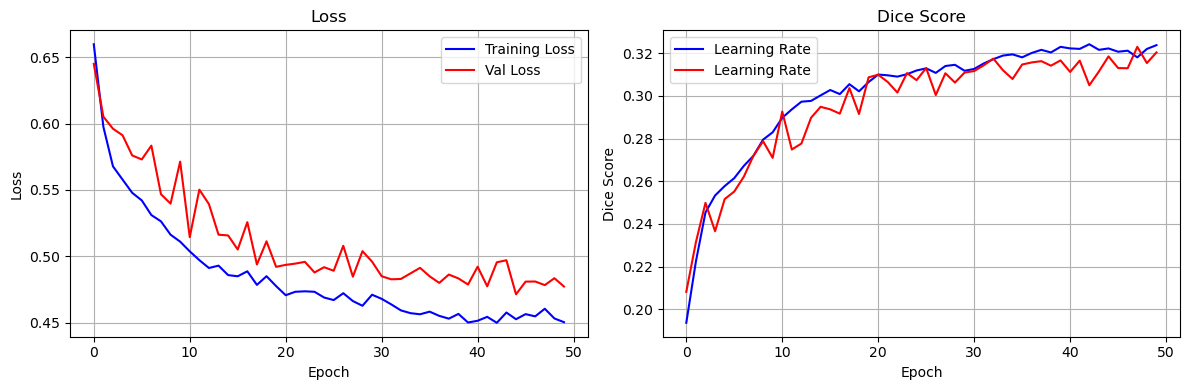

In [17]:
visualize_training_history(history_transUNet)

In [36]:
compute_dice_test(transUNet, test_loader, device)

Testing: 100%|██████████| 171/171 [00:13<00:00, 12.44it/s]

FINAL TEST RESULTS
Class 0 (Background): mean Dice = 0.9614 ± 0.0334
Class 1 (Neoplastic cells): mean Dice = 0.8085 ± 0.2623
Class 2 (Inflammatory): mean Dice = 0.7464 ± 0.3252
Class 3 (Connective/Soft tissue cells): mean Dice = 0.5906 ± 0.3223
Class 4 (Dead Cells): mean Dice = 0.9644 ± 0.1854
Class 5 (Epithelial): mean Dice = 0.9258 ± 0.2020

Mean Dice: 0.8328



Visualizing 4 predictions from test set


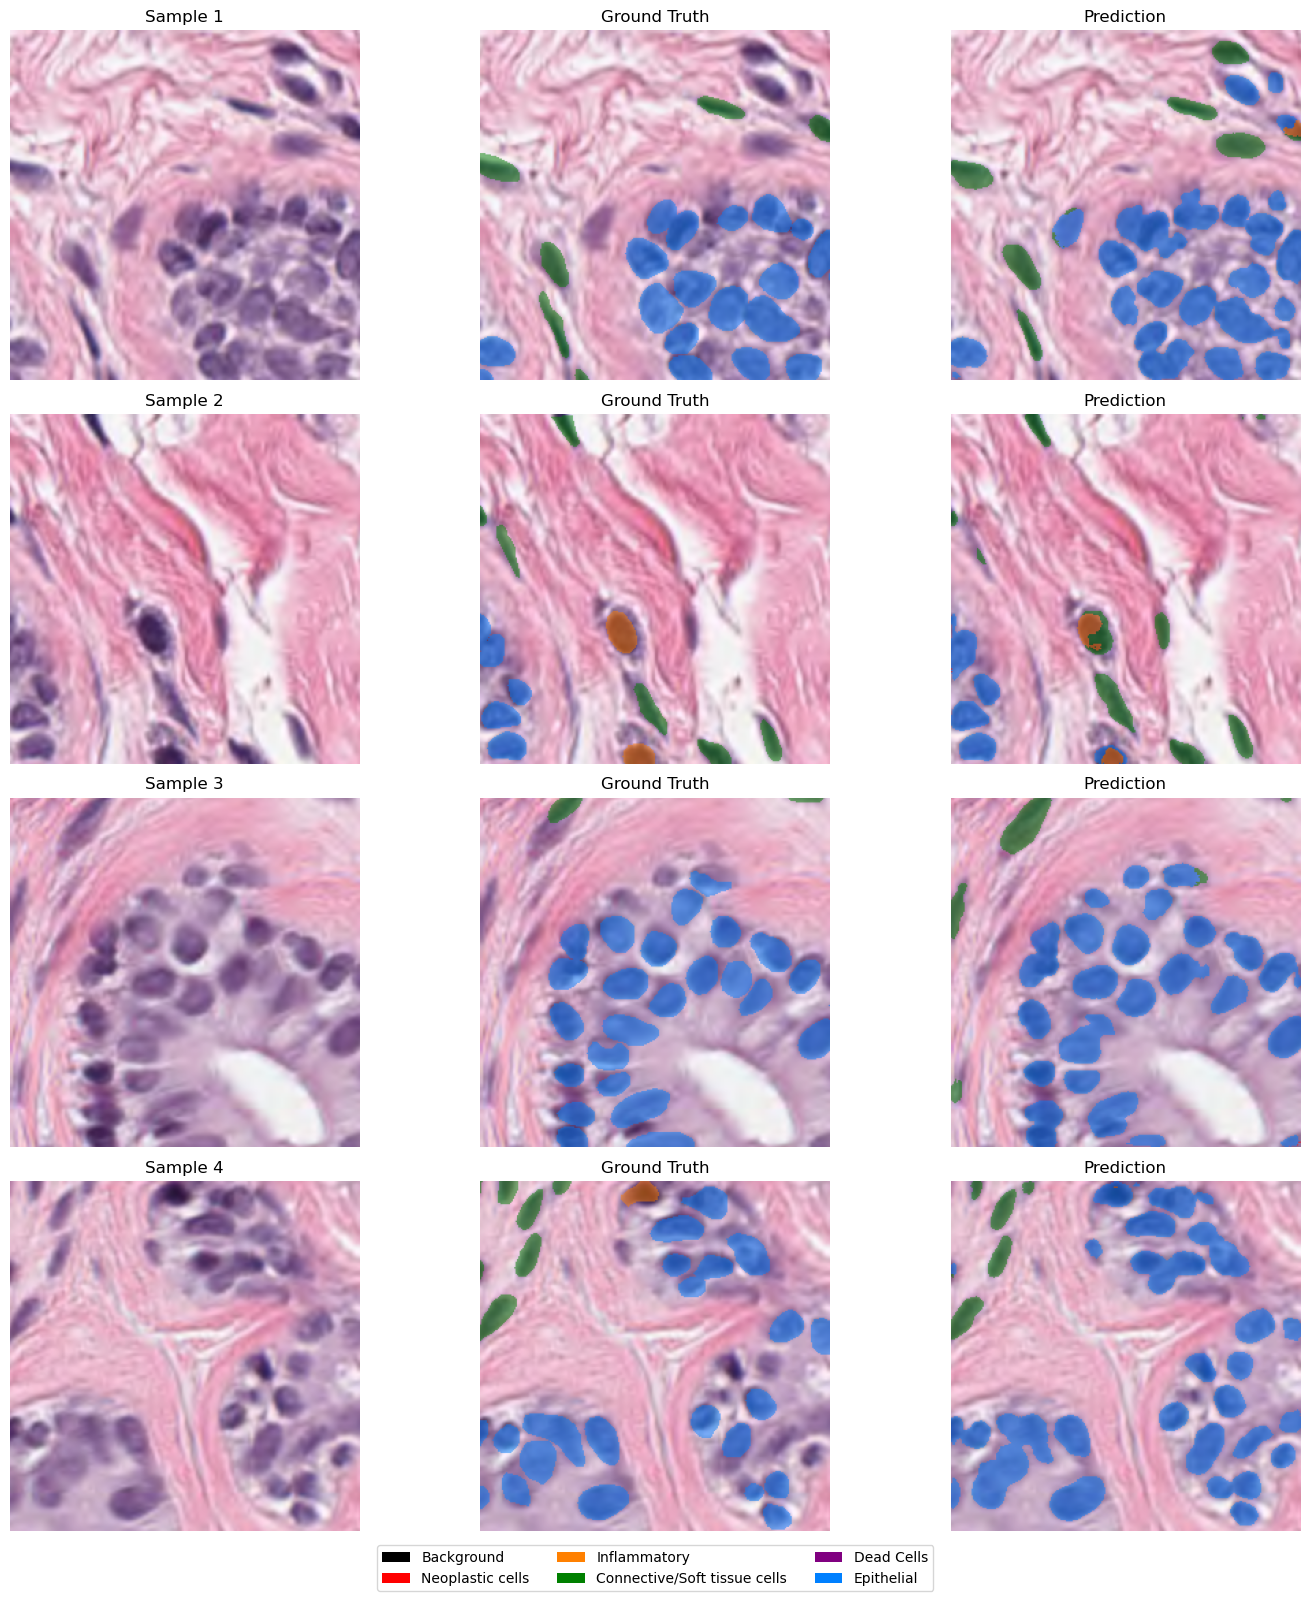

In [37]:
visualize_predictions(transUNet, test_loader, device)

# 6. Model Comparison

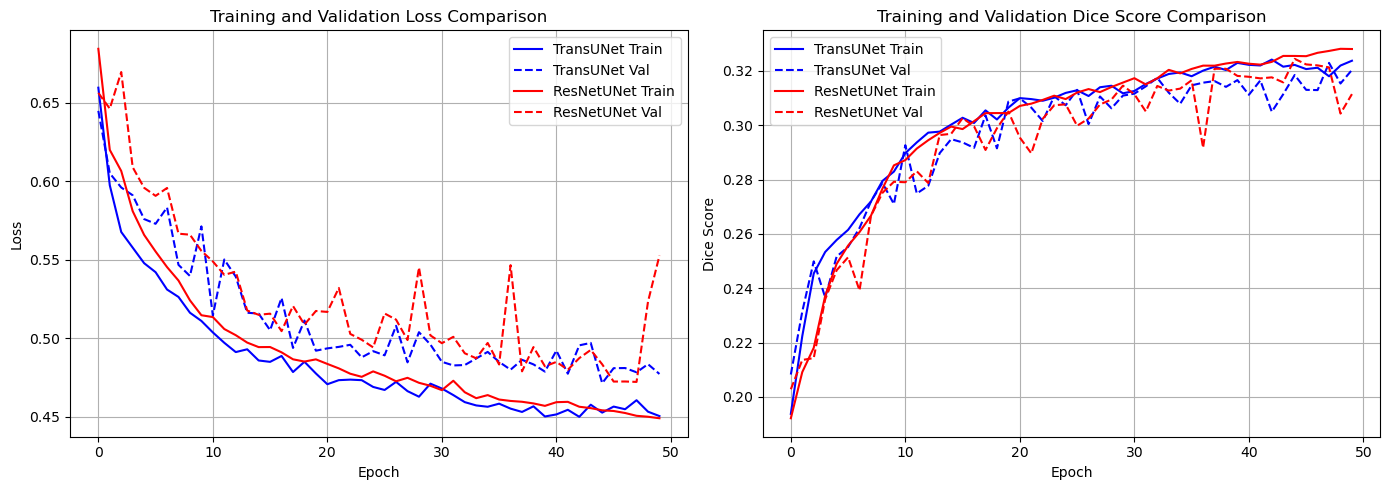

In [19]:
# Compare training histories
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(history_transUNet['train_loss'], label='TransUNet Train', color='blue')
axes[0].plot(history_transUNet['val_loss'], label='TransUNet Val', color='blue', linestyle='--')
axes[0].plot(history_resNetUNet['train_loss'], label='ResNetUNet Train', color='red')
axes[0].plot(history_resNetUNet['val_loss'], label='ResNetUNet Val', color='red', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss Comparison')
axes[0].legend()
axes[0].grid(True)

# Dice score comparison
axes[1].plot(history_transUNet['train_dice'], label='TransUNet Train', color='blue')
axes[1].plot(history_transUNet['val_dice'], label='TransUNet Val', color='blue', linestyle='--')
axes[1].plot(history_resNetUNet['train_dice'], label='ResNetUNet Train', color='red')
axes[1].plot(history_resNetUNet['val_dice'], label='ResNetUNet Val', color='red', linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 16. Side-by-Side Prediction Comparison

In [44]:
# Visualize predictions ensuring coverage with randomness: pick one random image per nuclei class (1..5)
if len(test_loader) > 0:
    resNetUNet.eval()
    transUNet.eval()
    target_classes = [1, 2, 3, 4, 5]
    # collect multiple candidates per class, then randomly sample one each run
    candidates = {c: [] for c in target_classes}  # class_id -> list[(img_cpu, gt_cpu)]
    max_batches_to_scan = min(10, len(test_loader))  # limit work and memory

    with torch.no_grad():
        for bi, batch in enumerate(tqdm(test_loader, desc="Collecting candidates")):
            images_cpu = batch['image']
            labels_cpu = batch['label']
            # Scan each sample in batch and add as candidates for any present class
            for i in range(images_cpu.size(0)):
                gt_i = labels_cpu[i]
                present = set(torch.unique(gt_i).tolist())
                for c in target_classes:
                    if c in present:
                        candidates[c].append((images_cpu[i], gt_i)) 
            if bi + 1 >= max_batches_to_scan and all(len(candidates[c]) > 0 for c in target_classes):
                break

    # Random selection per class
    selected = {}  # c -> (img_cpu, gt_cpu)
    for c in target_classes:
        if len(candidates[c]) > 0:
            idx = random.randrange(len(candidates[c]))
            selected[c] = candidates[c][idx]

    if len(selected) == 0:
        print("No qualifying samples found in test set.")
    else:
        # Randomize class order in the plot
        ordered = list(selected.keys())
        random.shuffle(ordered)

        # Batch predict for efficiency
        imgs_stack = torch.stack([selected[c][0] for c in ordered]).to(device)
        with torch.no_grad():
            outs1 = resNetUNet(imgs_stack)
            outs2 = transUNet(imgs_stack)
            preds1 = torch.argmax(outs1, dim=1).cpu()
            preds2 = torch.argmax(outs2, dim=1).cpu()

        num_viz = len(ordered)
        fig, axes = plt.subplots(num_viz, 4, figsize=(16, 4*num_viz))
        if num_viz == 1:
            axes = axes.reshape(1, -1)

        for row, c in enumerate(ordered):
            img = selected[c][0].numpy()
            gt_np = selected[c][1].numpy().astype(np.int32)
            p1_np = preds1[row].numpy().astype(np.int32)
            p2_np = preds2[row].numpy().astype(np.int32)

            axes[row, 0].imshow(img.transpose(1, 2, 0))
            axes[row, 0].set_title(f"Image (contains: {CLASS_NAMES.get(c, str(c))})")
            axes[row, 0].axis('off')

            gt_overlay = overlay_mask_on_image(img, gt_np, alpha=0.5, background_class=0)
            axes[row, 1].imshow(gt_overlay)
            axes[row, 1].set_title('Ground Truth')
            axes[row, 1].axis('off')

            p1_overlay = overlay_mask_on_image(img, p1_np, alpha=0.5, background_class=0)
            dice1 = np.mean(compute_dice_score(p1_np, gt_np, config["num_classes"]))
            axes[row, 2].imshow(p1_overlay)
            axes[row, 2].set_title(f'ResNetUNet (mDice: {dice1:.3f})')
            axes[row, 2].axis('off')

            p2_overlay = overlay_mask_on_image(img, p2_np, alpha=0.5, background_class=0)
            dice2 = np.mean(compute_dice_score(p2_np, gt_np, config["num_classes"]))
            axes[row, 3].imshow(p2_overlay)
            axes[row, 3].set_title(f'TransUNet (mDice: {dice2:.3f})')
            axes[row, 3].axis('off')

        legend_elements = create_legend()
        fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.03)
        plt.show()